In [2]:
import warnings
warnings.filterwarnings('ignore')

from src.prepare import telco_model_prep, telco_eda_prep
from src.helper_functions import plot_corr, calc_vif, output_preds, over_split, chi2_significance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

charizard = ['#FCC499', '#F2684A', '#FAAA6D', '#419EAE', '#FFEEB0']
sns.set_palette(sns.color_palette(charizard))

from scipy.stats import chi2, chi2_contingency, pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import eli5

# Should I Stay or Should I Go?

<img src="img/clash.png">


1. [Visuals](#1)


2. [Preprocessing](#2)
    * [Multicollinearity](#-)
    * [Synthetic Minority Oversampling](#-)
    * [Metric Selection](#-)


3. [Hypothesis Testing](#3)
    * [Chi-Squared](#-)
    * [Pearson Correlation](#-)


4. [Modeling](#4)
    * [kNN](#-)
    * [Decision tree](#-)
    * [Random forest](#-)
    * [Logistic regression](#-)


5. [McNemar's Test](#5)

6. [Recommendations](#6)


Customer's leaving, or churning, is a common problem in the telecommunications industry. It is a critical metric because it is much less expensive to retain existing customers than it is to acquire new ones. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

The data contains information about 7,043 customers, specifically:
* **Customers who left within the last month** – the column is called churn. 1,869 customers did it.
plt.pie(df.churn.value_counts(), labels=["Didn't churn 73%","Churned: 27%"], startangle=90);
* **Services that each customer has signed up for** – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

* **Customer account information** - how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

* **Demographic info about customers** – gender, age range, and if they have partners and dependents

In [2]:
df, eda = telco_model_prep(), telco_eda_prep()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   senior_citizen     7043 non-null   int64  
 2   tenure             7043 non-null   int64  
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   male               7043 non-null   uint8  
 6   partner            7043 non-null   uint8  
 7   dependents         7043 non-null   uint8  
 8   phone_service      7043 non-null   uint8  
 9   multiple_lines     7043 non-null   uint8  
 10  dsl                7043 non-null   uint8  
 11  fiber_optic        7043 non-null   uint8  
 12  online_security    7043 non-null   uint8  
 13  online_backup      7043 non-null   uint8  
 14  device_protection  7043 non-null   uint8  
 15  tech_support       7043 non-null   uint8  
 16  streaming_tv       7043 

The average customer pays **65 USD per month** and has been with the company for **32 months.** The median customers pays more (70 USD) but hasn't been a customer as long (29 months.) Do people who pay more leave sooner? In fact, no, they don't.

In [129]:
eda.describe()

,tenure,monthly_charges,total_charges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


<a id='1'></a>
## Visuals

To kick things off, pie chart that looks good enough to eat to show you how the extent of the churn problem.

### **~1 out of 4 customers left last month**

That's a lot of people heading for the door. What is this company doing to people?

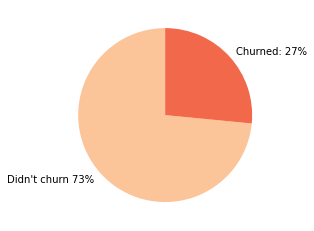

In [7]:
plt.pie(eda.churn.value_counts(), labels=["Didn't churn 73%","Churned: 27%"], startangle=90)
plt.savefig('img/pie.png')

"Okay, fine", you say, "But what do members of that dark orange slice have **in common**?" You ask a lot from me. Here's what I know.

* They **pay more** than the average customer.
* They are **month-to-month** customers. Some people can't commit to anything.
* They use internet, especially high-speed, **fiber optic** internet.
* They pay with **electronic checks**. What's that all about?

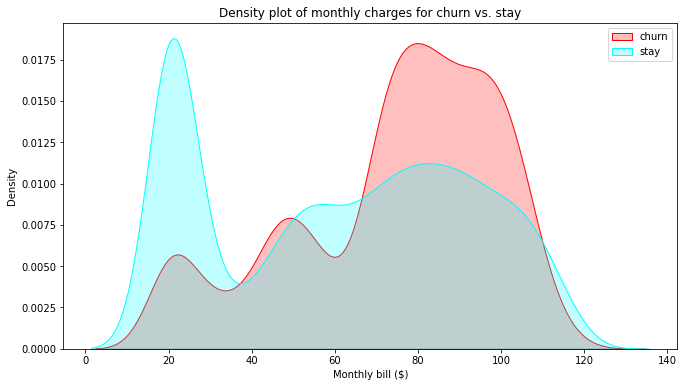

In [14]:
f=plt.subplots(figsize=(11,6))
ax=sns.kdeplot(eda.monthly_charges[eda.churn=='Yes'], fill=True, color='red')
ax=sns.kdeplot(eda.monthly_charges[eda.churn=='No'], fill=True, color='aqua')
ax.set_xlabel('Monthly bill ($)')
ax.legend(['churn','stay'])
ax.set_title("Density plot of monthly charges for churn vs. stay")
plt.savefig('img/density.png')

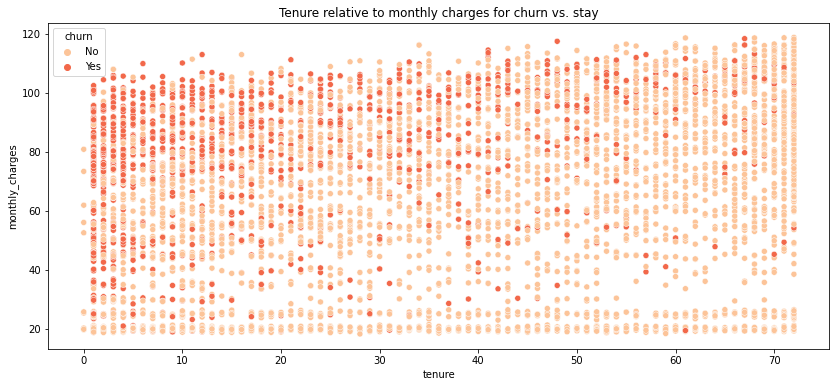

In [16]:
f=plt.subplots(figsize=(14,6))
ax=sns.scatterplot(eda.tenure, eda.monthly_charges, hue=eda.churn)
ax.set_title("Tenure relative to monthly charges for churn vs. stay")
plt.savefig('img/scatter.png')

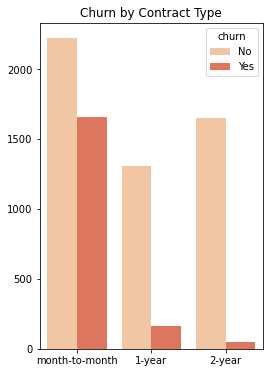

In [17]:
f=plt.subplots(figsize=(4,6))
ax=sns.countplot(data=eda, x='contract', hue='churn', order=['month-to-month','1-year','2-year'])
ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_title("Churn by Contract Type")
plt.savefig('img/hist_contract.png')

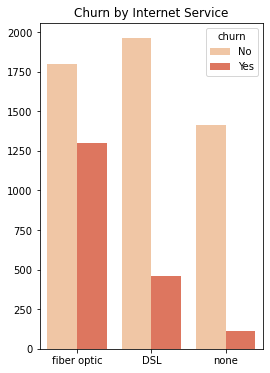

In [18]:
f=plt.subplots(figsize=(4,6))
ax=sns.countplot(data=eda, x='internet_service', hue='churn', order=['fiber optic','DSL','none'])
ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_title("Churn by Internet Service")
plt.savefig('img/hist_inter.png')

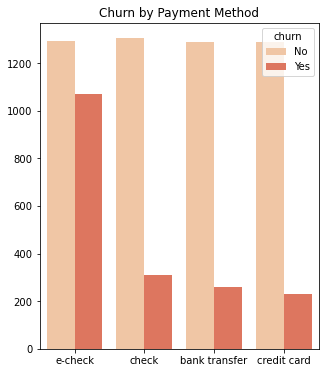

In [19]:
f=plt.subplots(figsize=(5,6))
ax=sns.countplot(data=eda, x='payment_method', hue='churn', order=['e-check','check','bank transfer', 'credit card'])
ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_title("Churn by Payment Method")
plt.savefig('img/hist_pay.png')

<a id='2'></a>
## Preprocessing

**Multicollinearity** is a problem because it undermines the statistical significance of an independent variable. It won't undermine the predictive power of machine learning algorithms so why bother? Two reasons. 1) Transferability - the model is unstable as small changes in features can cause disproportionately large swings in weight vectors. 2) Interpretability -  weight vectors change arbitrarily in logistic regression and SVM making feature importance unclear. Random forests will rank collinear features in a meaningless order. 


**VIF (Variable Inflation Factors)** are the most common tool for detecting multicollinearity. VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable. The VIF score of an independent variable represents how well the variable is explained by other independent variables.

* VIF starts at 1 and has no upper limit
* VIF = 1 -> no correlation between the independent variable and the other variables
* VIF exceeding 10 indicates high multicollinearity

(Sources: *Effects of Multicollinearity in Logistic Regression, SVM, Random Forest* by Shivam Raj and *What is Multicollinearity? Here’s Everything You Need to Know* by Aniruddha Bhandari)

In [3]:
churn = df.pop("churn") #first, isolate the dependent variable
calc_vif(df.iloc[:,1:])

,variables,VIF
0,senior_citizen,1.4
1,tenure,12.6
2,monthly_charges,4872.4
3,total_charges,17.6
4,male,2.0
5,partner,2.8
6,dependents,2.0
7,phone_service,354.6
8,multiple_lines,12.6
9,dsl,210.5


*Total charges* & *tenure* as well as *fiber optic* & *monthly charges* have the higest correlations at .83 and .79, respectively.

Total charges is the numerator in the tenure calculation, therefore, it is not surprising these features would display high correlation. It turns out that dropping the two charges columns fixes the inflation factor issue identified above. I wanted to keep fiber optic and tenure because they are distinct classes of customers, unlike charge-based ranking. Of note, reataining these features did not significantly affect model performance.

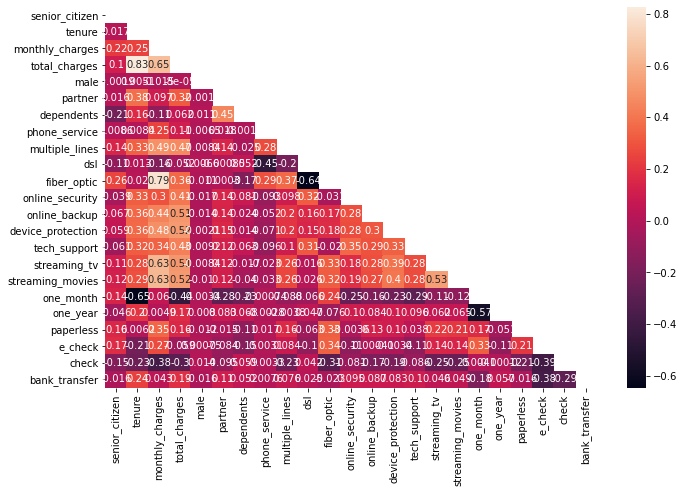

In [131]:
plot_corr(df);

In [4]:
df = df.drop(['monthly_charges', 'total_charges'], axis=1)

In [22]:
calc_vif(df.iloc[:,1:])

,variables,VIF
0,senior_citizen,1.4
1,tenure,5.7
2,male,2.0
3,partner,2.8
4,dependents,1.9
5,phone_service,8.4
6,multiple_lines,2.4
7,dsl,4.8
8,fiber_optic,7.2
9,online_security,2.0


<a id='4'></a>

### Synthetic Minority Oversampling Technique (SMOTE)

I trained each of the following models with and without oversampling the minority class (churn) using SMOTE, an algorithm that creates synthetic data using the k-nearest neighbors alforithm. In every instance, oversampling procuced a small decrease in accuracy with a comparable rise in the F1 score due to significant rise in recall. It makes sense that the model performed better at predicting the positive class when it had more positive examples in training. 

### Metric selection: F1 Score

#### "A theory that explains everything, explains nothing." -Karl Popper

<img src="img/popper.png">

Considering the business importance of predicting churn correctly, that is, minimizing the false negative rate (type II errors), maximizing the F1 score on the positive class is the best metric for this task. We already know that predicting no customers will churn produces a ~74 percent accuracy, however, such a model has no business value. Identifying churn, even if it means increasing false positives, is an excusable mistake because it means extra care was taken with a loyal customer rather than the a customer leaving without warning and without action. Simply predicting all customers will churn maxes out recall but makes too many errors to be useful. **That leaves F1**, the harmonic mean of precision and recall, to strike the ideal balance.

In [5]:
insig_vars = chi2_significance(df, churn)
df = df.drop(insig_vars, axis=1)

Observed
male      0     1
churn            
0      2549  2625
1       939   930
---
Expected
          0       1
No   2562.0  2612.0
Yes   926.0   943.0
---
Bonferroni correction = 4
chi^2 = 0.484
p     = 0.9999


Observed
phone_service    0     1
churn                   
0              512  4662
1              170  1699
---
Expected
         0       1
No   501.0  4673.0
Yes  181.0  1688.0
---
Bonferroni correction = 4
chi^2 = 0.915
p     = 0.9999




In [6]:
X_train, X_test, y_train, y_test, X_over, X_val, y_over, y_val = over_split(df, churn, .15)

X_train, X_test, y_train, y_test, X_over, X_val, y_over, y_val
(4929, 19) (1057, 20) (4929,) (1057,) (7242, 19) (1057, 19) (7242,) (1057,)


<a id='3'></a>
### Hypothesis Testing

#### Chi-Squared

**$χ^2$ contingency tables** can test the dependence of churn on every other categorical variable. If the observed contingency table for a variable did not differ significantly from the expected contingency table based on churn rates, I concluded that the variable is not useful for predicting churn.

Only *phone service* and *gender* were independent of churn on this basis (see cell above). (Dropping *phone service* had the added benefit of eliminating the feature with the highest multicollinearity.) In other words,

$H_0$ Gender is independent of churn.

$H_1$ Churn depends on gender.

Conclusion: **Do not reject the null** Gender is independent of churn.

#### Pearson correlation

Do monthly charges have a linear relationship with months of tenure? The scatter plot made any relationship appear dubious. I turned to the **Pearson correlation** coefficient.

$$\rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}$$

$H_0$ There is **no** linear correlation between monthly charges and months tenure.

$H_1$ There is a linear correlation between monthly charges and months tenure.

Conclusion: **Reject the null.** Although not glaringly obvious, there is a positive linear relationship, suggesting long-tenured customers pay more. It's important to acknowledge **survivorship bias** here. Customers unwilling to pay a lot aren't represented at higher tenures, driving up the average monthly bill over time.

In [124]:
corr, p = pearsonr(eda.monthly_charges, eda.tenure)
print(f'Pearson correlation = {corr:.3f}')
print(f'p-value             = {p:.3f}\n\n')

Pearson correlation = 0.248
p-value             = 0.000




A note on feature engineering: I attempted to engineer two features. Both had multicollinearity problems while offering no improvements to model performance.

* *Monthly charge bins* were collinear with fiber optic
* *Final month of contract* was .96 correlated with month-to-month

<a id='4'></a>
## Modeling

The baseline model predicts **all customers churn.**

It achieves an **F1 score of 0.42**, recall score of 1.0, and precision of 0.26.

Precision = $\frac{TP}{TP+FP}$

Recall = $\frac{TP}{TP+FN}$

F1 = $\frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

Note: The opposite (all zeros) produces an F1 of 0.

In [7]:
sns.set_palette(sns.color_palette("bone"))

cid = X_test.pop("customer_id") #needed for output file
pd.DataFrame(X_test.columns, columns=["features"]) #19 X-variables

,features
0,senior_citizen
1,tenure
2,partner
3,dependents
4,multiple_lines
5,dsl
6,fiber_optic
7,online_security
8,online_backup
9,device_protection


In [26]:
#using test data for comparison at end
print(classification_report(y_test, np.ones(len(y_test))))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       777
           1       0.26      1.00      0.42       280

    accuracy                           0.26      1057
   macro avg       0.13      0.50      0.21      1057
weighted avg       0.07      0.26      0.11      1057



### kNN

In [12]:
scores_in, scores_out = [], []
k_values = range(2,31,2)

for k in k_values:
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    knn.fit(X_train, y_train)
    scores_in.append(knn.score(X_train, y_train))
    scores_out.append(knn.score(X_val, y_val))                 

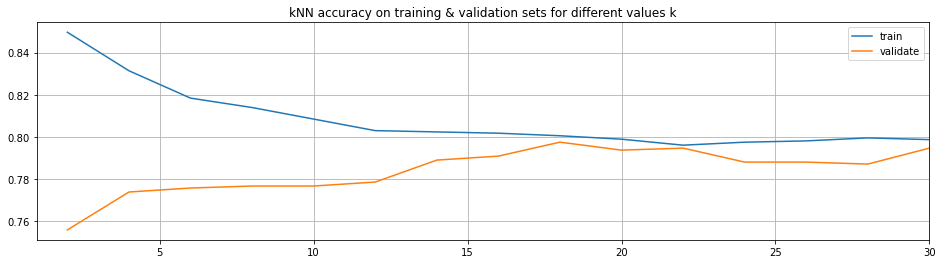

In [13]:
f = plt.subplots(figsize=(16,4))
plt.plot(k_values, scores_in)
plt.plot(k_values, scores_out)
plt.grid()
plt.xlim(1,30)
plt.legend(["train","validate"])
plt.title("kNN accuracy on training & validation sets for different values k");

In [18]:
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=16))

knn.fit(X_train, y_train)
y_pred =  knn.predict(X_val)
print(classification_report(y_val, knn.predict(X_val)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       776
           1       0.63      0.51      0.56       281

    accuracy                           0.79      1057
   macro avg       0.73      0.70      0.71      1057
weighted avg       0.78      0.79      0.78      1057



              precision    recall  f1-score   support

           0       0.89      0.77      0.82       776
           1       0.53      0.74      0.62       281

    accuracy                           0.76      1057
   macro avg       0.71      0.75      0.72      1057
weighted avg       0.79      0.76      0.77      1057



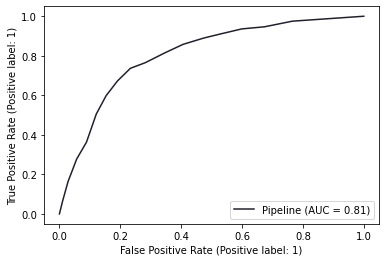

In [13]:
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=16))
knn.fit(X_over, y_over)
print(classification_report(y_val, knn.predict(X_val)))
plot_roc_curve(knn, X_val, y_val);

### Decision tree

From the sklearn documentation:

"The DecisionTreeClassifier provides parameters such as min_samples_leaf and max_depth to prevent a tree from overfiting. **Cost complexity pruning** provides another option to control the size of a tree. In DecisionTreeClassifier, this pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first."

In [28]:
#ccp_alpha prunes weak links based on impurity, a perfect 100% impure node splits evenly (50/50) whereas a 100% pure (useless) node classifies all samples to one class
for a in np.array(range(50, 100, 5))/10000:
    dt = DecisionTreeClassifier(ccp_alpha=a, random_state=36).fit(X_over, y_over)
    y_pred = dt.predict(X_val)
    print(f"alpha: {a}, recall: {round(recall_score(y_val, y_pred),2)}, f1: {round(f1_score(y_val, y_pred),2)}")    

alpha: 0.005, recall: 0.73, f1: 0.61
alpha: 0.0055, recall: 0.73, f1: 0.61
alpha: 0.006, recall: 0.78, f1: 0.61
alpha: 0.0065, recall: 0.78, f1: 0.61
alpha: 0.007, recall: 0.78, f1: 0.61
alpha: 0.0075, recall: 0.78, f1: 0.61
alpha: 0.008, recall: 0.78, f1: 0.61
alpha: 0.0085, recall: 0.78, f1: 0.61
alpha: 0.009, recall: 0.78, f1: 0.61
alpha: 0.0095, recall: 0.78, f1: 0.61


In [29]:
#very low recall
dt = DecisionTreeClassifier(ccp_alpha=.007, random_state=36)
dt.fit(X_train, y_train)
print(classification_report(y_val, dt.predict(X_val)))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       776
           1       0.75      0.35      0.47       281

    accuracy                           0.80      1057
   macro avg       0.78      0.65      0.67      1057
weighted avg       0.79      0.80      0.77      1057



              precision    recall  f1-score   support

           0       0.90      0.72      0.80       776
           1       0.50      0.78      0.61       281

    accuracy                           0.74      1057
   macro avg       0.70      0.75      0.71      1057
weighted avg       0.79      0.74      0.75      1057



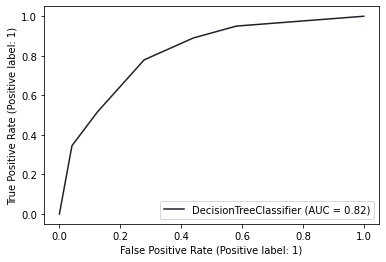

In [30]:
dt = DecisionTreeClassifier(ccp_alpha=.007, random_state=36)
dt.fit(X_over, y_over)
print(classification_report(y_val, dt.predict(X_val)))
plot_roc_curve(dt, X_val, y_val);

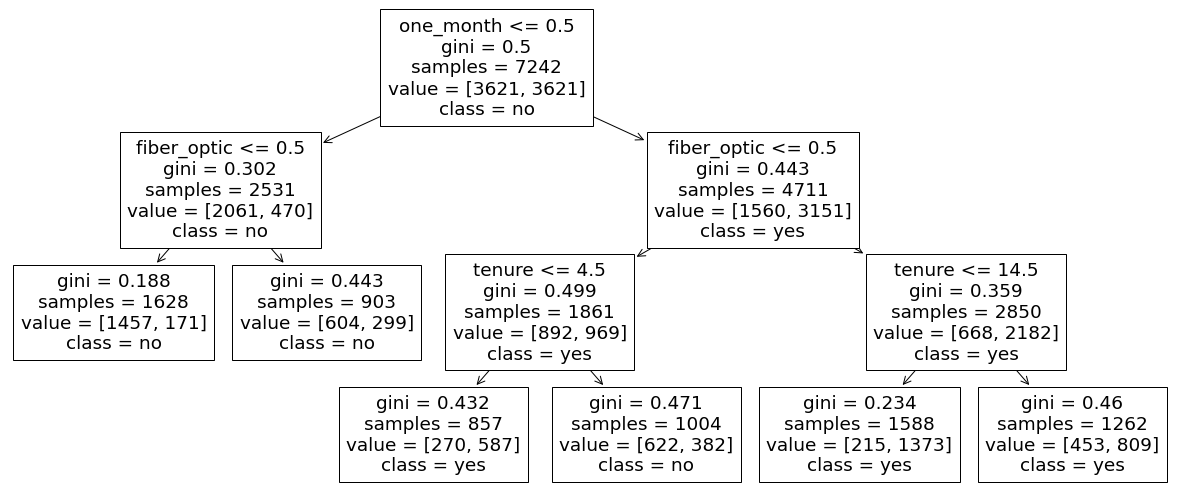

In [31]:
plt.figure(figsize=(21,9))
plot_tree(dt, feature_names=X_val.columns, class_names=['no','yes']);

### Random forest

In [32]:
for a in np.array(range(10, 100, 10))/10000:
    rf = RandomForestClassifier(ccp_alpha=a, random_state=36).fit(X_over, y_over)
    y_pred = rf.predict(X_val)
    print(f"alpha: {a}, recall: {round(recall_score(y_val, y_pred),2)}, f1: {round(f1_score(y_val, y_pred),2)}")    

alpha: 0.001, recall: 0.73, f1: 0.62
alpha: 0.002, recall: 0.79, f1: 0.63
alpha: 0.003, recall: 0.81, f1: 0.63
alpha: 0.004, recall: 0.82, f1: 0.62
alpha: 0.005, recall: 0.82, f1: 0.62
alpha: 0.006, recall: 0.81, f1: 0.61
alpha: 0.007, recall: 0.82, f1: 0.61
alpha: 0.008, recall: 0.83, f1: 0.62
alpha: 0.009, recall: 0.83, f1: 0.61


              precision    recall  f1-score   support

           0       0.91      0.73      0.81       776
           1       0.52      0.81      0.63       281

    accuracy                           0.75      1057
   macro avg       0.72      0.77      0.72      1057
weighted avg       0.81      0.75      0.76      1057



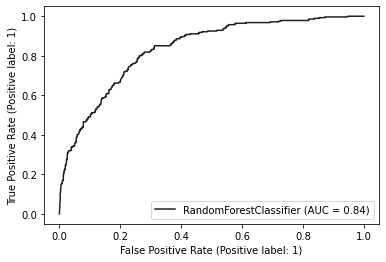

In [40]:
rf = RandomForestClassifier(ccp_alpha=.003, random_state=36)
rf.fit(X_over, y_over)
print(classification_report(y_val, rf.predict(X_val)))
plot_roc_curve(rf, X_val, y_val);

In [34]:
#ranked importance based on Gini index
eli5.show_weights(rf, feature_names=list(X_val.columns))

Weight,Feature
0.2734 ± 0.4664,one_month
0.2019 ± 0.3306,tenure
0.1434 ± 0.2380,fiber_optic
0.0728 ± 0.2266,e_check
0.0686 ± 0.1725,online_security
0.0548 ± 0.1532,tech_support
0.0421 ± 0.1386,one_year
0.0280 ± 0.1165,dependents
0.0254 ± 0.0756,check
0.0215 ± 0.0563,dsl


#### Bonus model: Naive Bayes

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       776
           1       0.54      0.71      0.61       281

    accuracy                           0.76      1057
   macro avg       0.71      0.75      0.72      1057
weighted avg       0.79      0.76      0.77      1057



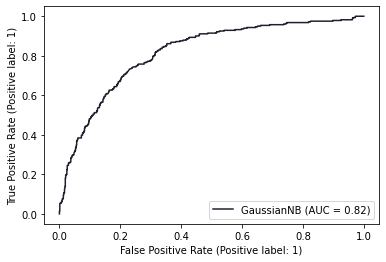

In [17]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test) #does better without SMOTE
print(classification_report(y_val, gnb.predict(X_val)))
plot_roc_curve(gnb, X_val, y_val);

### Logistic regression

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       776
           1       0.53      0.72      0.61       281

    accuracy                           0.76      1057
   macro avg       0.71      0.75      0.72      1057
weighted avg       0.79      0.76      0.77      1057



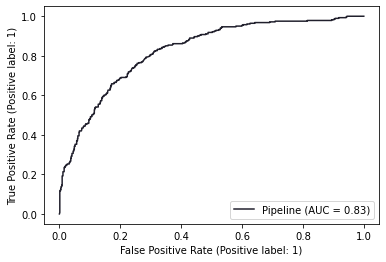

In [35]:
lr = make_pipeline(StandardScaler(),LogisticRegression(C=.1, random_state=36))
#same story: without oversampled data, F1 is very low
lr.fit(X_over, y_over)
print(classification_report(y_val, lr.predict(X_val)))
plot_roc_curve(lr, X_val, y_val);

In [36]:
eli5.show_weights(lr, feature_names=list(X_val.columns))

Weight?,Feature
+0.721,fiber_optic
+0.238,one_month
+0.219,dsl
+0.125,streaming_movies
+0.106,streaming_tv
+0.097,paperless
+0.001,multiple_lines
-0.065,senior_citizen
-0.078,<BIAS>
-0.094,partner


Fewer features made a better model. I took the top three features from the all-variable model as well as e-check since it looked important in EDA but wasn't used much in the above model.

              precision    recall  f1-score   support

           0       0.93      0.69      0.79       776
           1       0.50      0.85      0.63       281

    accuracy                           0.73      1057
   macro avg       0.71      0.77      0.71      1057
weighted avg       0.81      0.73      0.75      1057



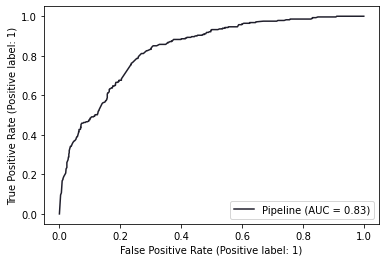

In [8]:
selected = ['fiber_optic', 'one_month', 'tenure', 'e_check']

lr = make_pipeline(StandardScaler(),LogisticRegression(C=.1, random_state=36))
lr.fit(X_over[selected], y_over)
print(classification_report(y_val, lr.predict(X_val[selected])))
plot_roc_curve(lr, X_val[selected], y_val);

<a id='5'></a>

## McNemar’s Test

The random forest, decision tree, and logistic regressor were so close in F1 scores that it was a toss up choosing the best one. A paired Student's t-test with cross-fold validation is often used to compare predictions among models but this is technically incorrect since the samples are not independent. Hence the need for McNemar's test.

**McNemar’s test** operates upon a contingency table similar to Chi-Squared. In fact, **the test statistic has a Chi-Squared distribution with 1 degree of freedom.** McNemar’s test is a paired nonparametric or distribution-free statistical hypothesis test. The test is checking if the disagreements between two cases match. Here is how the statistic is calculated.

test statistic = (Yes/No - No/Yes)^2 / (Yes/No + No/Yes)

where Yes/No is the count of test instances that Classifier 1 got correct and Classifier 2 got incorrect, and No/Yes is the count of test instances that Classifier 1 got incorrect and Classifier 2 got correct, assuming a minimum of 25 of each.

This calculation of the test statistic assumes that each cell in the contingency table used in the calculation has a count of at least 25. 
The statistic is reporting on the different correct or incorrect predictions between the two models, not the accuracy or error rates.

$H_0$ The two models disagree to the same amount.

$H_1$ There is evidence that the cases disagree in different ways, that the disagreements are skewed.

(Source: *How to Calculate McNemar’s Test to Compare Two Machine Learning Classifiers* by Jason Brownlee)

In [45]:
for c1, c2 in [[rf, lr], [rf, dt], [dt, lr]]:
    #Logistic regression model trained on fewer features.
    if c2 == lr:
        obs = pd.crosstab(c1.predict(X_val)==y_val, c2.predict(X_val[selected])==y_val)
    else:
        obs = pd.crosstab(c1.predict(X_val)==y_val, c2.predict(X_val)==y_val)
    
    yn, ny = obs.iloc[1,0], obs.iloc[0,1]
    t, ddof = (yn - ny)**2 / (yn + ny), 1
    p = chi2.sf(t, ddof)
    print(obs)
    print(f"  McNemar's t-stat: {round(t,2)}, p-value: {round(p,2)}\n")

churn  False  True 
churn              
False    233     32
True      48    744
  McNemar's t-stat: 3.2, p-value: 0.07

churn  False  True 
churn              
False    229     36
True      49    743
  McNemar's t-stat: 1.99, p-value: 0.16

churn  False  True 
churn              
False    242     36
True      39    740
  McNemar's t-stat: 0.12, p-value: 0.73



<img src="img/chi2_table.png">

My significance level was **0.10.**

**Conclusions:**

**Reject the null** The RF and LR models are making different predictions.

**Do not reject the null** The RF and DT models disagree to the same amount.

**Do not reject the null** The LR and DT models disagree to the same amount.

For the final step, I output the logistic regression and decision tree predictions to a file. Although it's a toss up on performance, my choice is the decision tree because it is so damn simple.

In [50]:
output_preds(lr, X_test[selected], y_test, cid)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, random_state=36))]), 
    recall: 0.82,
    precision: 0.51,
    f1: 0.63,
    accuracy: 0.74


In [51]:
output_preds(dt, X_test, y_test, cid)

DecisionTreeClassifier(ccp_alpha=0.007, random_state=36), 
    recall: 0.79,
    precision: 0.52,
    f1: 0.63,
    accuracy: 0.75


### Did we do better than the baseline? 

**Before:** Out of 100 customers, identifies all as a having a 1/4 chance of churning.

**After:** Out of 100 customers, picks out 40 and this subset includes 20 of 25 churning customers.

<img src="img/dilute.png">


The value of the model is, 1) It identifies primary drivers of churn and, 2) It identifies a subset of customer's on whom to focus retention efforts.

<img src="img/tree.jpg" width="500">


In [3]:
pd.DataFrame([[.26, 1., .42, .26, 1057], [.52, .79, .63, .75, 1057]],
             columns=["Precision","Recall","F1","Accuracy", "support"],
            index=["baseline", "decision tree"])

,Precision,Recall,F1,Accuracy,support
baseline,0.26,1.00,0.42,0.26,1057
decision tree,0.52,0.79,0.63,0.75,1057


<a id='6'></a>

#### Key points

* Addressing multicollinearity improves interpretability.
* Oversampling more than doubles recall on positive class.
* Only 3-4 features were necessary for the best model: tenure, month-to-month, fiber optic, & e-check.

## Recommendations

    Make a real-time prediction page using Flask.
    
    Have a team of salespeople call high-risk customers and perhaps offer a discount on internet.
    
    Acquire more data for a better model. Deep learning on a much larger dataset could produce a very high accuracy.
    
    Conduct satisfaction surveys. Are there qualitative factors at play not captured here?